<a href="https://colab.research.google.com/github/Vamsi-Malineni/work/blob/master/Steady_state_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==1.15.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 26 kB/s 
     |████████████████████████████████| 3.8 MB 48.2 MB/s 
     |████████████████████████████████| 503 kB 67.7 MB/s 
     |████████████████████████████████| 50 kB 8.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=44882d62bde9b4c06c7d45fe890eec76ae7e3a807db6e9fd7aca1b65f80f7399
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=f94244e530235f7102760697771f47ba2403ad1a247050234fe06b7903d27884
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [4]:
import tensorflow as tf
import numpy as np
import scipy.io
import time
import pandas as pd
import math
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import copy
from pyDOE import lhs

In [17]:
# set random seed
np.random.seed(1234)
tf.set_random_seed(1234)


class pinn:
    # Initialize the class
    #model = pinn(domain_data,boundary_data,layers,N_train,batch_size,load=False,file=None)
    def __init__(self, domain_data, boundary_data, layers, N_train, batch_size,load = False, file=None):
        
#============================================================================================================================#
#=============================================Loading data ==================================================================#
#============================================================================================================================#
        self.data_sup_b_train = boundary_data
        self.data_idx = domain_data

        self.N_train = N_train
        self.batch_size=batch_size

        # Check why this is here 
        self.lowb = self.data_idx.min(0)  
        self.upb = self.data_idx.max(0)

        self.layers = layers

#============================================================================================================================#
#=======================================Loading / Initializing NN============================================================#
#============================================================================================================================#
        if load==True:
            # collecting weights and biases from the pickle file
            self.weights,self.biases,ac_bc=self.load_parameters(file,self.layers)
            
            # The adaptive constants are added here so as to start training from a check point
            self.beta=0.9
            self.adaptive_constant_bcs_val=ac_bc

        if load ==False:
            # Initializing weights and biases for model using xavier initialization method.
            self.weights, self.biases = self.initialize_NN(layers)

            # Adaptive weighting constants initialized to 1.
            self.beta=0.9
            self.adaptive_constant_bcs_val=np.array(1.0)  # arw for boundary conditions

#============================================================================================================================#
#=============================================Specifying Placeholders========================================================#
#============================================================================================================================#

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        # learning rate placeholder
        self.learning_rate = tf.placeholder(tf.float32, shape=[])
        
       
        # boundary condition placeholders
        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc1_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc2_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc3_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc4_tf = tf.placeholder(tf.float32, shape=(None, 2))

        # domain residual placeholders
        self.x_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, 1])

        # defining a placeholder for adaptive constant
        self.adaptive_constant_bcs_tf=tf.placeholder(tf.float32,shape=self.adaptive_constant_bcs_val.shape)
        
#============================================================================================================================#
#=============================================Evaluating Predictions=========================================================#
#============================================================================================================================#

        
        # Boundary value predictions

        self.u_bc1_pred, self.v_bc1_pred,_,_,_,_= self.net_f_NS(self.x_bc1_tf, self.y_bc1_tf)
        self.u_bc2_pred, self.v_bc2_pred,_,_,_,_= self.net_f_NS(self.x_bc2_tf, self.y_bc2_tf)
        self.u_bc3_pred, self.v_bc3_pred,_,_,_,_= self.net_f_NS(self.x_bc3_tf, self.y_bc3_tf)
        self.u_bc4_pred, self.v_bc4_pred,_,_,_,_= self.net_f_NS(self.x_bc4_tf, self.y_bc4_tf)
        
        self.U_bc1_pred = tf.concat([self.u_bc1_pred, self.v_bc1_pred], axis=1)
        self.U_bc2_pred = tf.concat([self.u_bc2_pred, self.v_bc2_pred], axis=1)
        self.U_bc3_pred = tf.concat([self.u_bc3_pred, self.v_bc3_pred], axis=1)
        self.U_bc4_pred = tf.concat([self.u_bc4_pred, self.v_bc4_pred], axis=1)

        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_e_pred =self.net_f_NS(self.x_tf, self.y_tf)

#============================================================================================================================#
#=============================================Defining loss fn===============================================================#
#============================================================================================================================#

        self.loss_bcs=self.adaptive_constant_bcs_tf*(tf.reduce_mean(tf.square(self.U_bc1_pred - self.U_bc1_tf)+
                                                                    tf.square(self.U_bc2_pred - self.U_bc2_tf)+
                                                                    tf.square(self.U_bc3_pred - self.U_bc3_tf)+
                                                                    tf.square(self.U_bc4_pred - self.U_bc4_tf)))

        
        # Defining loss function for residual in the domain 
        
        self.loss_res= tf.reduce_mean(tf.square(self.f_u_pred)) + tf.reduce_mean(tf.square(self.f_v_pred)) + tf.reduce_mean(tf.square(self.f_e_pred))


        # set loss function
        self.loss =self.loss_res + self.loss_bcs

#============================================================================================================================#
#=============================================Setting up optimizer===========================================================#
#============================================================================================================================#
        self.global_step=tf.Variable(0,trainable=False)
        starter_learning_rate=1e-3
        # Setting up exponential decay of learning rate as training progresses
        self.learning_rate=tf.train.exponential_decay(starter_learning_rate,self.global_step,1000,0.9,staircase=False)

        # setup lbfgs optimizer
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method='L-BFGS-B',
                                                                options={'maxiter': 50000,
                                                                         'maxfun': 50000,
                                                                         'maxcor': 50,
                                                                         'maxls': 50,
                                                                         'ftol': 1.0 * np.finfo(float).eps})

        # setup adam optimizer
        self.optimizer_Adam = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss,global_step=self.global_step)

#============================================================================================================================#
#=============================================Adaptive weighting constants===================================================#
#============================================================================================================================#

        # Collecting gradients of the individual loss terms wrt the parameters of the network
        self.grad_res=[]
        self.grad_bcs=[]
        
        for i in range(len(self.layers)-1):
          self.grad_res.append(tf.gradients(self.loss_res,self.weights[i])[0])
          self.grad_bcs.append(tf.gradients(self.loss_bcs,self.weights[i])[0])
        
        # Collecting the adaptive constants for initial and boundary conditions
        self.adaptive_constant_bcs_list=[]

        self.adaptive_constant_bcs_log=[]

        for i in range(len(self.layers)-1):
          self.adaptive_constant_bcs_list.append(
              tf.reduce_max(tf.abs(self.grad_res[i])) / tf.reduce_mean(tf.abs(self.grad_bcs[i]))
          )
        
        self.adaptive_constant_bcs=tf.reduce_max(tf.stack(self.adaptive_constant_bcs_list))
        
#============================================================================================================================#
#=============================================initializing session===========================================================#
#============================================================================================================================#

        # Initializing Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

#============================================================================================================================#
#=============================================Data in batches================================================================#
#============================================================================================================================#

        # Creating batches for domain data
    def summon_batch_domain(self,batch_size,start):
      ''' 
      This function returns a list containing randomnly picked points from the domain
      '''
      data=copy.deepcopy(self.data_idx)
      points=[]

      for i in range(start,len(data),batch_size): # Something is wrong here

        points.append(data[i:i+batch_size,0:3])
        break # breaks after the first iteration

      return points

    def domain_batches(self,batch_size):
      '''
      This function is used to call the domain data points in batches
      This function returns an array of arrays of shape(438,1) each of the 438 arrays
      will have batch size number of points
      '''
      batches=[]
      num_batches=math.ceil(self.N_train/batch_size)

      for i in range(0,len(data_idx),batch_size):
        batches.append(self.summon_batch_domain(batch_size,i))

      return np.asarray(batches,dtype=object) 

# Creating batches for initial conditions
    def summon_batch_ic(self,batch_size,start):

      data=copy.deepcopy(data_t0)
      points=[]

      for i in range(start,len(data),batch_size): 

        points.append(data[i:i+batch_size])
        break # breaks after the first iteration

      return points
    def ic_batches(self,batch_size):
      batches=[]
      num_batches=math.ceil(self.data_t0.shape[0]/batch_size)

      for i in range(0,len(self.data_t0),batch_size):
        batches.append(self.summon_batch_ic(batch_size,i))

      return np.asarray(batches,dtype=object)       

# Creatng batches for boundary condition
    def summon_batch_bc(self,batch_size,bc_con,start):
      
      if bc_con==1:
        data=copy.deepcopy(data_sup_b_train[0:20000,:])
      elif bc_con==2:
        data=copy.deepcopy(data_sup_b_train[20000:40000,:])
      elif bc_con==3:
        data=copy.deepcopy(data_sup_b_train[40000:60000,:])
      elif bc_con==4:
        data=copy.deepcopy(data_sup_b_train[60000:80000,:])

      points=[]

      for i in range(start,len(data),batch_size): 

        points.append(data[i:i+batch_size])
        break # breaks after the first iteration

      return points	
    
    def bc_batches(self,batch_size,bc_con):

      batches=[]
      
      for i in range(0,int(len(data_sup_b_train)/4),batch_size):
        batches.append(self.summon_batch_bc(batch_size,bc_con,i))

      return np.asarray(batches,dtype=object) 

#============================================================================================================================#
#=============================================Utility fns= ==================================================================#
#============================================================================================================================#

# initialize the weights and biases
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

# xavier used to initialize the weight
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

#===========================================================================================================#
#====================================Transfer Learning======================================================#
#===========================================================================================================#
    def save_parameters(self,fileDr):
        weights=self.sess.run(self.weights)
        biases= self.sess.run(self.biases)
        
        ac_bc=(self.adaptive_constant_bcs_val)
                
        root_path=Path("D:\Vamsi\Python scripts")
        my_path=root_path/fileDr
        
        with open(my_path,'wb') as f:
            pickle.dump([weights,biases,ac_bc],f)
            print("Parameters are saved in pickle file")

    def load_parameters(self,fileDr,layers):
        tf_weights=[]
        tf_biases=[]
        num_layers=len(layers)
        
        root_path=Path("D:\Vamsi\Python scripts")
        my_path=root_path/fileDr
        
        # returns the weights and biases of the network as np array
        with open(my_path,'rb') as f:
            weights,biases,ac_bc=pickle.load(f)
            assert num_layers == (len(weights)+1)
        
        # returns the weights and biases of the network as tf.variable
        for num in range(0,num_layers-1):
            W=tf.Variable(weights[num])
            b=tf.Variable(biases[num])
            tf_weights.append(W)
            tf_biases.append(b)
         
        
        print("Parameters are loaded succesffuly")
        
        return tf_weights,tf_biases,ac_bc
    
    
#============================================================================================================================#
#=============================================Neural_net setup===============================================================#
#============================================================================================================================#


    def neural_net(self, X):
        num_layers = len(self.weights) + 1

        H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0

        for l in range(0, num_layers - 2):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = self.weights[-1]
        b = self.biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    # supervised data driven
    def net_NS(self, x, y):

        
        psi_p = self.neural_net(tf.concat([x, y], 1))
        psi = psi_p[:, 0:1]
        p   = psi_p[:, 1:2]
        
        u=tf.gradients(psi,y)[0]
        v=(-1) * tf.gradients(psi,x)[0]

        return u, v, p

    # unsupervised NS residual
    def net_f_NS(self, x, y):

        psi_p = self.neural_net(tf.concat([x, y], 1))
        psi = psi_p[:, 0:1]
        p   = psi_p[:, 1:2]
        
        u=tf.gradients(psi,y)[0]
        v=(-1) * tf.gradients(psi,x)[0]
        
        
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]

        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]

        p_x = tf.gradients(p, x)[0]
        p_y = tf.gradients(p, y)[0]

        f_u = (u * u_x + v * u_y) + p_x - 0.01 * (u_xx + u_yy)
        f_v = (u * v_x + v * v_y) + p_y - 0.01 * (v_xx + v_yy)
        f_e = 0.0

        return u, v, p, f_u, f_v, f_e

    def callback(self, loss):
        print('Loss: %.3e' % loss)

#============================================================================================================================#
#=============================================Training algorithms============================================================#
#============================================================================================================================#


    def Adam_train(self, epochs=5000,file_save='',file_path=''):

        start_time = time.time()
        tf_dict = {

              self.x_bc1_tf: self.data_sup_b_train[0][:,0:1] ,# boundary conditions
              self.y_bc1_tf: self.data_sup_b_train[0][:,1:2], 
              self.U_bc1_tf: self.data_sup_b_train[0][:,3:5],

              self.x_bc2_tf: self.data_sup_b_train[1][:,0:1] ,
              self.y_bc2_tf: self.data_sup_b_train[1][:,1:2] , 
              self.U_bc2_tf: self.data_sup_b_train[1][:,3:5] ,

              self.x_bc3_tf: self.data_sup_b_train[2][:,0:1] ,
              self.y_bc3_tf: self.data_sup_b_train[2][:,1:2] , 
              self.U_bc3_tf: self.data_sup_b_train[2][:,3:5] ,

              self.x_bc4_tf: self.data_sup_b_train[3][:,0:1] ,
              self.y_bc4_tf: self.data_sup_b_train[3][:,1:2] , 
              self.U_bc4_tf: self.data_sup_b_train[3][:,3:5] ,

              self.x_tf: self.data_idx[:,0:1] , # domain 
              self.y_tf: self.data_idx[:,1:2] , 

              self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val}

        for epoch in (range(epochs)):

            # add the tf dict here 
            self.sess.run(self.train_op_Adam, tf_dict)

            # Print
            if epoch % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                adaptive_constant_bcs_val=self.sess.run(self.adaptive_constant_bcs,tf_dict)

                self.adaptive_constant_bcs_val=adaptive_constant_bcs_val* (1.0-self.beta)+self.beta*self.adaptive_constant_bcs_val

                print('epoch: %d, Loss: %.3e, Time: %.2f' %
                      (epoch, loss_value, elapsed))
                print("constant_bcs_val: {:.3f}".format(self.adaptive_constant_bcs_val))
                start_time = time.time()

                # fil=open(file_path,"w")
                # fil.writelines("epoch: "+str(it)+" "+"\n"+"loss: "+str(loss_value)+"\n"+" elapsed: "+str(elapsed))
                # fil.flush()
            
            if epoch !=0 and epoch %1000==0:
               self.save_parameters(file_save)

# two step train BFGS used to finetune the result
    def BFGS_train(self):

        tf_dict = {self.x_ini_tf: self.x0, self.y_ini_tf: self.y0,
                   self.t_ini_tf: self.t0, self.u_ini_tf: self.u0,
                   self.v_ini_tf: self.v0, self.x_boundary_tf: self.xb,
                   self.y_boundary_tf: self.yb, self.t_boundary_tf: self.tb,
                   self.u_boundary_tf: self.ub, self.v_boundary_tf: self.vb,
                   self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t}

        self.optimizer.minimize(self.sess,
                                feed_dict=tf_dict,
                                fetches=[self.loss],
                                loss_callback=self.callback)

#============================================================================================================================#
#=============================================Predicting for test_data=======================================================#
#============================================================================================================================#


    def predict(self, x_star, y_star, t_star):

        tf_dict = {self.x_tf: x_star, self.y_tf: y_star}

        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)

        return u_star, v_star, p_star

# Load data and plotting data


In [5]:

def dom_data(N_train,min_max):
    xmax,xmin,ymax,ymin=min_max
    lb=np.array(([xmin,ymin]))
    ub=np.array(([xmax,ymax]))

    colloc_points=lb+(ub-lb)*lhs(2,N_train)

    return colloc_points

def load_data(N_train,num_bound_pts,flag=False):
    path=r"/content/drive/MyDrive/steady_state_data"

    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()

    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()

    press=pd.read_csv(path+r"/press.csv")
    press=press.to_numpy()

    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()

    # need add unsupervised part
    x=xy[:,0:1]
    y=xy[:,1:2]

    ax=np.unique(x)
    xmin=min(ax)
    xmax=max(ax)

    ay=np.unique(y)
    ymin=min(ay)
    ymax=max(ay)


    # # Concatenating all the points
    data_domain=np.concatenate([x ,y , uvel , vvel ,press ],1)
    # # Defining boundary conditions for the data
    bc1_data=data_domain[:,:][data_domain[:,1]==ymax]
    bc2_data=data_domain[:,:][data_domain[:,0]==xmin]
    bc3_data=data_domain[:,:][data_domain[:,0]==xmax]
    bc4_data=data_domain[:,:][data_domain[:,1]==ymin]

    # # Creating boundary conditions dataset size=(80000,6)

    if flag == True:
            data_sup_b_train = [bc1_data,bc2_data,bc3_data,bc4_data]
        
    # If you want to train the model on randomly selected points across time flag ful----> False
    else:
        bidx = np.random.choice(bc1_data.shape[0], num_bound_pts, replace=True)

        # Randomly selecting points on boundary conditions from 20000
        bc1=bc1_data[bidx]
        bc2=bc2_data[bidx]
        bc3=bc3_data[bidx]
        bc4=bc4_data[bidx]

        data_sup_b_train=[bc1,bc2,bc3,bc4]
    
    min_max=[xmax,xmin,ymax,ymin]
    colloc_points =dom_data(N_train,min_max)
    
    return colloc_points,data_sup_b_train


def scatter(domain_data,boundary_data):
    x=domain_data[:,0:1]
    y=domain_data[:,1:2]

    b1=boundary_data[0]
    b2=boundary_data[1]
    b3=boundary_data[2]
    b4=boundary_data[3]

    xb1=b1[:,0:1]
    xb2=b2[:,0:1]
    xb3=b3[:,0:1]
    xb4=b4[:,0:1]

    yb1=b1[:,1:2]
    yb2=b2[:,1:2]
    yb3=b3[:,1:2]
    yb4=b4[:,1:2]

    bc1=plt.scatter(xb1,yb1,c='blue',s=10)
    bc2=plt.scatter(xb2,yb2,c='green',s=10)
    bc3=plt.scatter(xb3,yb3,c='black',s=10)
    bc4=plt.scatter(xb4,yb4,c='yellow',s=10)
    dom=plt.scatter(x,y,c='red',s=1)

    plt.legend((dom,bc1,bc2,bc3,bc4),
    ('domain','bc1','bc2','bc3','bc4'),loc='lower left',
    ncol=2,fontsize=8)
    plt.show()


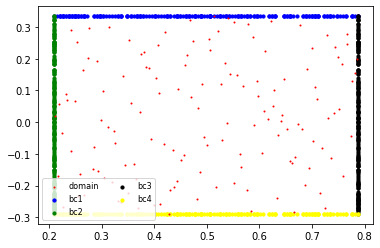

In [9]:
N_train = 140000
N_bound = 200
    
dd,bd=load_data(N_train,N_bound,False)
scatter(dd,bd)

# Running PINN

In [ ]:

if __name__ == "__main__":

    N_train = 140000
    N_bound = 200
    batch_size= 32

    layers = [2, 50,50,50, 2]
    #layers=[3]+10*[4*50]+[2]
    
    # loading data
    domain_data,boundary_data=load_data(N_train,N_bound,False)
    
    # Initializing the model for training
    model = pinn(domain_data,boundary_data,layers,N_train,batch_size,load=False,file=None)
    
#     Initializing model for testing by loading the pickle file
#     filedr='' # Enter the name of the pickle file
#     model= pinn(data_idx,data_t0,data_sup_b_train,layers,N_train,batch_size,load=True,file=filedr)
    
#     Enter the name of the parameters file
    file_save='params_pr' 
    file_path=r'C:\Users\vamsi_oe20s302\Desktop\tf_test.txt'

#      Training the model
    model.Adam_train(200000,file_save,file_path)




Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

epoch: 0, Loss: 4.270e-01, Time: 6.17
constant_bcs_val: 1.914
epoch: 10, Loss: 1.214e-01, Time: 4.48
constant_bcs_val: 3.308
epoch: 20, Loss: 8.985e-02, Time: 4.49
constant_bcs_val: 7.356
epoch: 30, Loss: 6.604e-02, Time: 4.50
constant_bcs_val: 7.963
epoch: 40, Loss: 5.456e-02, Time: 4.51
constant_bcs_val: 8.209
epoch: 50, Loss: 4.812e-02, Time: 4.56
constant_bcs_val: 9.132
epoch: 60, Loss: 4.483e-02, Time: 4.58
constant_bcs_val: 11.283
epoch: 70, Loss: 4.289e-02, Time: 4.53
constant_bcs_val: 12.343
epoch: 80, Loss: 4.142e-02, Time: 4.54
constant_bcs_val: 12.552
epoch: 90, Loss: 4.024e-02, Time: 4.55
constant_bcs_val: 12.257
epoch: 100, Loss: 3.930e-02, Time: 4.56
constant_bcs_val: 11.782
epoch: 110

# Testing model

In [ ]:
def load_testdata(snap):
    path=r"/content/drive/MyDrive/all_pressures"

    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()

    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()

    press=pd.read_csv(path+r"/static_press.csv")
    press=press.to_numpy()
    
    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()
    
    t=pd.read_csv(path+r"/time.csv")
    t=t.to_numpy()
    
    N=xy.shape[0]
    T=t.shape[0]
    
    TT = np.tile(t, (1,N)).T # N x T
    
    x_star = xy[:, 0:1]
    y_star = xy[:, 1:2]
    t_star = TT[:, snap]
    X_star=[x_star,y_star,t_star]
    
    u_star = uvel[:, snap]
    v_star = vvel[:, snap]
    p_star = press[:, snap]
    Y_star=[u_star,v_star,p_star]
    
    return X_star,Y_star

In [ ]:
# # Testing the load functionality for errors :
# filedr='params_3_laptop_run' # Enter the name of the pickle file
# model= pinn(data_idx,data_t0,data_sup_b_train,layers,N_train,batch_size,load=True,file=filedr)


# # Prediction
X_star,Y_star=load_testdata(np.array([100]))
u_pred, v_pred, p_pred = model.predict(X_star[0],X_star[1],X_star[2])

# # Error
error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
error_v = np.linalg.norm(Y_star[1] - v_pred, 2) / np.linalg.norm(Y_star[1], 2)
error_p = np.linalg.norm(Y_star[2] - p_pred, 2) / np.linalg.norm(Y_star[2], 2)

print('Error u: %e' % error_u)
print('Error v: %e' % error_v)
print('Error p: %e' % error_p)

In [ ]:
uplot=np.reshape(u_pred,(100,100))
plt.imshow(uplot)
plt.title("Predicted u_velocity")
plt.colorbar()

In [ ]:
upl=np.reshape(Y_star[0],(100,100))
plt.imshow(upl)
plt.title("Actual u_velocity")
plt.colorbar()